# Simulate a noisy 16-QAM

This tutorial presents the steps for simulating a noisy 16-QAM modulation scheme with [AFF3CT](https://aff3ct.github.io/). At the end of this, tutorial you will have built the following communication sequence.

<a id='com_chain'></a>
![16QAM_sequence](https://aff3ct.github.io/images/doc_py_aff3ct/16QAM_chain.svg)

## Load the `py_aff3ct` library
Before going farther, we should import the `py_aff3ct` library. The sys library is requiered to add the library path to your path (you can also simply copy the library into the current directory if you prefer). 

For this example, we will also need the `numpy` and the `matplotlib` libraries. You can install these libraries with `pip` as follow on Ubuntu 20.04:
```bash
$ sudo apt install python3-pip
$ pip3 install --user -r requirements.txt
```

In [36]:
import sys  
sys.path.insert(0, '../build/lib')

import py_aff3ct

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
%qtconsole

## Build the `modules`
We start by building all the necessary objects for our simulation:
* a `Source_random` for generating the bits
* an `Encoder_repetition_sys`for encoding the message, here using a repetition code
* a `Modem_generic`for modulating/demodulating the bits as 16-QAM symbols
* a `Channel_AWGN_LLR` that adds a White Gaussian Noise (AWGN channel)
* a `Decoder_NO` that decide the demodulation output to recover the bits
* a `Monitor_BFER_AR` that counts the number of errors and compute the Binary Error Rate (BER) and Frame Error Rate (FER) and perform Automatic Reduction (for enabling multi-threaded simulations)

In [38]:
K   = 2048   # Message size in bits
N   = 4096   # Packet length in bits
bps = 4      # Bits per Symbols   
Ns  = N//bps # Packet size in symbols

src  = py_aff3ct.module.source.Source_random(K)             # Build source
enc  = py_aff3ct.module.encoder.Encoder_repetition_sys(K,N) # Build the encoder
cstl = py_aff3ct.tools.constellation.Constellation_QAM(bps) # Setup constellation tool
mdm  = py_aff3ct.module.modem.Modem_generic(N, cstl)        # Build the modem
chn  = py_aff3ct.module.channel.Channel_AWGN_LLR(2*Ns)      # Build the channel (Ns complex symbols = 2Ns real dims)
dec  = py_aff3ct.module.decoder.Decoder_repetition_std(K,N) # Build the decoder
mnt  = py_aff3ct.module.monitor.Monitor_BFER_AR(K,100)      # Build the monitor (counting errors)

## Bind the `tasks`
Now we can bind the different tasks in order to create the processing sequence described in [this picture](#com_chain).

In [39]:
enc[      'encode::U_K' ].bind(src[   'generate::U_K' ]) # Source       -> Encoder
mdm[    'modulate::X_N1'].bind(enc[     'encode::X_N' ]) # Encoder      -> Modulation
chn[   'add_noise::X_N' ].bind(mdm[   'modulate::X_N2']) # Modulation   -> Channel
mdm[  'demodulate::Y_N1'].bind(chn[  'add_noise::Y_N' ]) # Channel      -> Demodulation
dec[ 'decode_siho::Y_N' ].bind(mdm[ 'demodulate::Y_N2']) # Demodulation -> Decoder
mnt['check_errors::U'   ].bind(src[   'generate::U_K' ]) # Source       -> Monitor
mnt['check_errors::V'   ].bind(dec['decode_siho::V_K' ]) # Decoder      -> Monitor

<a id='sigma_def'></a>
If you look at the information for tasks `add_noise` and `demodulate`, you will found out that a socket named `CP` should be filled. `CP` stands for "Channel Parameter", which for Additive White Gaussian Noise (AWGN) channel, represents the noise standard deviation. Let now fill this socket with a user defined value. 

In [40]:
sigma = np.ndarray(shape = (1,1),  dtype = np.float32)
sigma[0] = 0.05

chn[ 'add_noise::CP'].bind(sigma)
mdm['demodulate::CP'].bind(sigma)
print("Channel Parameter (CP) for 'chn':", chn[ 'add_noise::CP'][:])
print("Channel Parameter (CP) for 'mdm':", mdm['demodulate::CP'][:])

Channel Parameter (CP) for 'chn': [[0.05]]
Channel Parameter (CP) for 'mdm': [[0.05]]


## Execute the sequence of `tasks`
Now that the binding is performed, we can execute the our sequence.

In [41]:
src('generate'   ).exec()
enc('encode'     ).exec()
mdm('modulate'   ).exec()
chn('add_noise'  ).exec()
mdm('demodulate' ).exec()
dec('decode_siho').exec()

As in the Hello World tutorial, we can recover `socket` data and then display its constellation diagram using `matplotlib`.

In [42]:
sent_signal = mdm[  'modulate::X_N2'][:]
recv_signal = mdm['demodulate::Y_N1'][:]

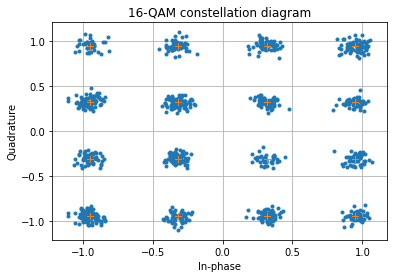

In [43]:
plt.plot(recv_signal[0, ::2], recv_signal[0, 1::2], '.')
plt.plot(sent_signal[0, ::2], sent_signal[0, 1::2], '+')
plt.title("16-QAM constellation diagram")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")
plt.grid()

In [44]:
mnt('check_errors').debug = True
mnt('check_errors').set_debug_limit(8)
mnt('check_errors').exec()
mnt('check_errors').debug = False

# Monitor_BFER_AR::check_errors(const int32 U[2048], const int32 V[2048])
# {IN}  U = [    0,     1,     1,     0,     1,     1,     1,     1, ...]
# {IN}  V = [    0,     1,     1,     0,     1,     1,     1,     1, ...]
# Returned status: [0 'SUCCESS']
#


Changing the value of `sigma` [here](#sigma2_def) and re-executing the following cells should change the returned status of the `Monitor_BFER` module.

## Compute BER/FER as a function of Eb/N0
A common way for validating a communication chain is to compute Bit Error Rates or Frame Error Rates as a function of SNR (here we choose the SNR per information bit named Eb/N0). This operation includes most of the operations performed in the first part of this tutorial.

So we first specify the vector of Eb/N0 values that we want to consider and convert these values to `sigma` values.

In [45]:
import math

ebn0_min = 0
ebn0_max = 15.0
ebn0_step = 0.5

ebn0 = np.arange(ebn0_min,ebn0_max,ebn0_step)
esn0 = ebn0 + 10 * math.log10(K/Ns)
sigma_vals = 1/(math.sqrt(2) * 10 ** (esn0 / 20))

fer = np.zeros(len(ebn0))
ber = np.zeros(len(ebn0))

Because BER/FER simulations are often time consuming, AFF3CT provide a tool that enables multithreading. This tool is called `sequence`. The second advantages of sequences is that execution is performed automatically at the sequence level(it is deduced from the binding steps), we do not need to execute each task independently as before. A sequence can be built from the initial `task`, the final `task` and the desired number of threads for the simulation.

In [46]:
n_threads = 8
seq = py_aff3ct.tools.sequence.Sequence(src("generate"), mnt("check_errors"), n_threads)

We loop over all `sigma` values and just execute the sequence. The monitor is reset each time to reset the error counter. Once the execution is over, we simply store the monitor BER and FER.

In [47]:
for i in range(len(sigma_vals)):
    mnt.reset()
    sigma[:] = sigma_vals[i]
    seq.exec()

    ber[i] = mnt.get_ber()
    fer[i] = mnt.get_fer()

Finally we display the BER/FER vs Eb/N0 curves using `matplotlib`

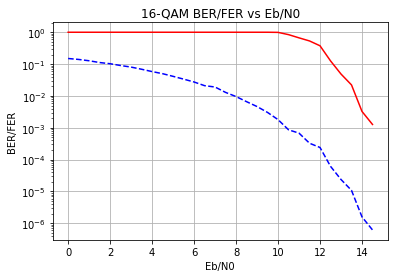

In [48]:
fig = plt.figure()
plt.title("16-QAM BER/FER vs Eb/N0")
plt.xlabel("Eb/N0")
plt.ylabel("BER/FER")
plt.grid()
plt.semilogy(ebn0, fer, 'r-', ebn0, ber, 'b--')
plt.show()